## Importing essential Python Packages

In [2]:
import os, sys

import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import optimize
from scipy.optimize import minimize
from astropy.io import fits
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

`sbfTools` hold all the auxiliary functions we use in this notebook.
Make sure that `sbfTools.py` is in located in the same folder as this notebook.

In [3]:
# make sure 
from sbfTools import *

## `get_RMS` 

Defining the `rms` of the flux deviations from the `r^1/4` profile, extrapolated in the outer regions of the target galaxy

In [4]:
def get_RMS(obj, r0, r1, nr, sky_factor):
    '''
    
    Returns:
        - rms: the rms of deviations
        - n_cross: number of ellipses crossing each other
    
    '''
    
    sky = int(sky_factor*obj.sky_med)
    n_cross = 0
    
    if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=1, model_mask=0) != 'OK':
        n_cross+=1
        
    model = 0 
    n_cross += Xellipses(obj.list_ellipses(model=0))
    root = obj.objRoot
    suffix = '.%03d'%model

    ellipseFile = root+'/elliprof'+suffix
    df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
    df = df.apply(pd.to_numeric, errors='coerce')
    x = df.Rmaj**0.25
    y = 2.5*np.log10(df.I0)

    maxX = np.max(x)
    minX = np.min(x)
    dx = maxX-minX
    x1 = 0.60*dx+minX
    x2 = maxX-0.20*dx
    x3 = maxX-0.10*dx
    x0 = x[((x<x2) & (x>x1))]
    y0 = y[((x<x2) & (x>x1))]

    m, b = np.polyfit(x0, y0, 1)

    x_data = x[((x>=x3))]
    y_data = y[((x>=x3))]
    y_model = m*x_data+b

    rms = np.sqrt(np.mean((y_data.values-y_model.values)**2))
    
    return rms, n_cross


def get_f(obj, r0, r1, nr):
    '''
    
    
    Returns:
        - func: a function that gets the sky_factor and returns the rms of deviations
        This function in its heart uses function `get_RMS` 
    
    '''
    
    def func(sky_factor):

        rms, n_cross = get_RMS(obj, r0, r1, nr, sky_factor)

        sig = rms 

        if sig>10 or np.isnan(sig) or n_cross>0:
            sig = 10

        return -sig
    
    return func

In [5]:
#https://math.stackexchange.com/questions/1114879/detect-if-two-ellipses-intersect

## Object Initialization

In [6]:
## This is the folder that holds recent observations by wfc3 on HST in a SNAP program

inFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/'

In [7]:
# obj = ellOBJ("n0679")
obj = ellOBJ("u12517")
# obj = ellOBJ("n0439")


# obj = ellOBJ("n3308", inFolder=inFolder)

# obj = ellOBJ("n7265", inFolder=inFolder)

# obj = ellOBJ("n7426", inFolder=inFolder)

## very bright nearby object
# obj = ellOBJ("n6577", inFolder=inFolder)

# obj = ellOBJ("ic4727", inFolder=inFolder)

# obj = ellOBJ("ic0380", inFolder=inFolder)

## arms, shells
# obj = ellOBJ("n2418", inFolder=inFolder)

## doesn't exist
# obj = ellOBJ("e137008", inFolder=inFolder)

# obj = ellOBJ("u11990", inFolder=inFolder)

# bright nearby object
# obj = ellOBJ("n3268", inFolder=inFolder)

# obj = ellOBJ("n7274", inFolder=inFolder)

### Spiral arms, reject
# obj = ellOBJ("n6688", inFolder=inFolder)

## nuclear dust + companion
# obj = ellOBJ("n4825", inFolder=inFolder)

# obj = ellOBJ("n6768", inFolder=inFolder)

# obj = ellOBJ("n6223", inFolder=inFolder)

In [8]:
obj.sky_med, obj.x0, obj.y0

(3607.26513671875, 567.631, 562.615)

In [9]:
obj.x_max, obj.y_max

(1022, 1025)

In [10]:
r = min([obj.x0, obj.x_max-obj.x0, obj.y0, obj.y_max-obj.y0])

r, int(obj.r_max)

(454.369, 454)

Back Median: 3607.27
Back Mean: 3607.38
Back Stdev: 123.42


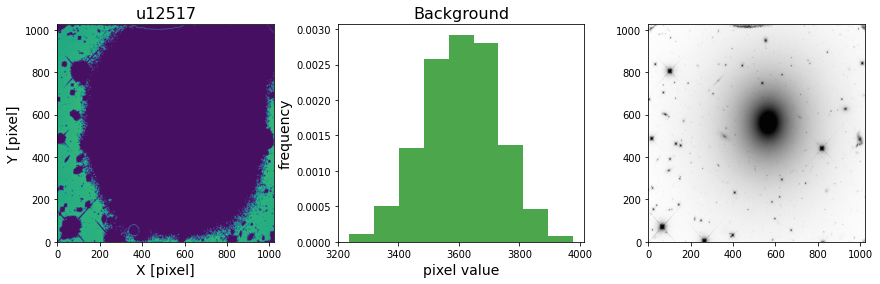

In [14]:
obj.backSextract(thresh=0.03)
ax1, ax2, ax3 = obj.plot_background()

Here, we do a crude calculations to generate an initial mask. The main objective is to mask out the large objects in the field.

- `minArea`: the minimum number of pixels in the masked regions
- `thresh`: the threshold factor that represents the signal to noise ratio of the detected segmented areas. Larger values would reduce the number of masked, because larger signal levels would satisfy the threshold condition.
- `smooth`: the smoothing factor. Larger values would enlarge the masked regions, because the signal is smeared across more neighborhood pixels.
- `mask=1`: the mask number. By default we start from `1`. However any other arbitrary integer value could be used.


*The segmentation and the associated generated mask are plotted.*
One may play with the input values to generate satisfactory initial masks.

Text(0.5, 1.0, 'Mask')

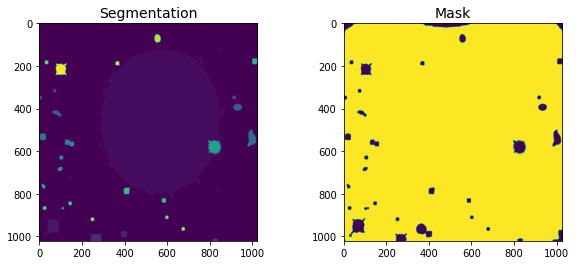

In [15]:
ax1, ax2 = obj.naive_Sextract(minArea=200, thresh=3, mask=0, smooth=5)
ax1.set_title("Segmentation", fontsize=14)

obj.addMasks(maskList=[0], mask=1)
im, h = obj.maskOpen(mask=1)
ax2.imshow(np.flipud(im))
ax2.set_title("Mask", fontsize=14)

## Running Elliprof

Here, we run `elliprof` for the firt time. The initial mask that was generated above (e.g. mask=1) is utilized here and `model=0` is created. Usually, the Kron_radius factor is set to a value greater than 2 and smaller than 4.
The main goal is to generate very crude model.

- `r0`: Inner radius to fit
- `r1`: Outer radius to fit, i.e. `obj.outerR(c_kron)`, where `outerR` takes the Kron radius factor and converts it to number of pixels
- `c_kron`: Kron radius factor
- `sky`: sky value, which is roughly about 90% of the median of the values of the background pixels. *Note:* The sky level would be fine tuned later.
- `k`: A factor to determine the number of fitting radii, i.e. `nr=r1/k`
- `options`: Any other that `elliprof` accepts. 

N_cross: 0
r0: 3
r1: 248
nr: 17
sky: 3246
CPU times: user 674 ms, sys: 538 ms, total: 1.21 s
Wall time: 841 ms


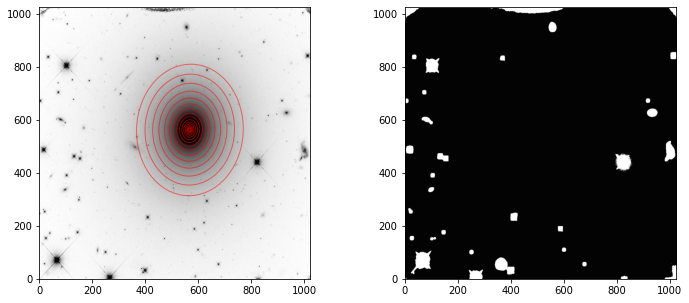

In [17]:
%%time

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))


r0 = 3              # pixel
c_kron = 2.5     # Kron radius factor
k = 15 
sky_factor = 0.9    # always less than one

r1 = obj.outerR(c_kron)
nr = int(np.round(r1/k))
sky = int(sky_factor*obj.sky_med)

## input mask. Usually mask = 1 or any value chosen for the initial mask from the previous cell
## since we have not specify the model number, the generated model takes a value of `0`
msg = obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="", mask=1)

## Calculating the number of crossing ellipses, the generated model = 0, from previous linen_cross = Xellipses(obj.list_ellipses(model=0))
obj.tv(options="log", ax=ax1)
obj.plot_ellipse(model=0, ax=ax1, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

print("N_cross: %d"%n_cross)
print("r0: %d"%r0)
print("r1: %d"%r1)
print("nr: %d"%nr)
print("sky: %d"%sky)

obj.tv_mask(mask=1, ax=ax2)

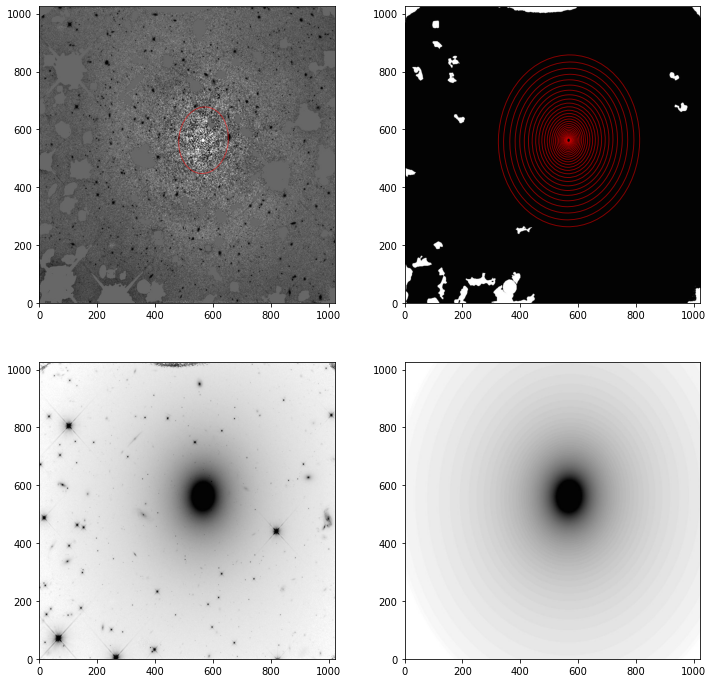

In [154]:
r0 = 7   # pixels
r1 = obj.outerR(3)   # *kron_radius
nr = int(np.round(r1/10))
sky_factor = 0.85    # always less than one
   
# using mask=1
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med*sky_factor, niter=10, mask=1, model_mask=0, options='cos3x=-1')

# using residuals of model 0 --> mask 2
obj.objSEextract(model=0, smooth=4, minArea=500, thresh=2, mask=2) 

# plotting model 0

fig, ax = plt.subplots(2, 2, figsize=(12,12))

obj.tv_resid(model=0, ax = ax[0][0], options='sqrt')
Ell = ((obj.x0, obj.y0), 1.*obj.a, 1.*obj.b, obj.angle)
e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], 
                    alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')
ax[0][0].add_patch(e)

obj.tv_mask(mask=2, ax = ax[0][1])
obj.plot_ellipse(model=0, ax=ax[0][1], alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')


obj.tv(ax = ax[1][0], options='sqrt')
obj.tv_model(model=0, ax=ax[1,1], options='sqrt')



In [153]:
# combining mask1 and mask2 ----> mask1
obj.addMasks(maskList=[1,2], mask=1)

'Outputs_u12517//mask.001'

In [109]:
First = True

for i in range(25):
    
    sky = sky_factor*obj.sky_med

    if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=1, model_mask=0) != 'OK':
        print("Err")
        break


    resid_name = obj.objRoot+"resid.000"
    back_mask = obj.objRoot+"back_mask.fits"

    imarray, header = imOpen(resid_name)
    mskarray, header = imOpen(back_mask)

    masked_image = imarray*mskarray


    a = masked_image
    a = a[(a!=0)]
    std = np.std(a)
    mean = np.mean(a)

    a = a[((a>mean-3.*std)&(a<mean+3.*std))]

    median = np.median(a)
    mean = np.mean(a)
    std = np.std(a)

    sky_factor = median/obj.sky_med + sky_factor
    
    abs_median = np.abs(median)
    if First:
        min_absmed = abs_median
        min_factor = sky_factor
        min_med = median 
        First = False
    elif abs_median<min_absmed:
        min_absmed = abs_median
        min_factor = sky_factor
        min_med = median       
    

    if i%5==0:
        print("%02d median:%.2f factor:%.4f"%(i, median, sky_factor))

print("Optimum --- median:%.2f factor:%.4f"%(min_med, min_factor))
sky_factor = min_factor

00 median:-143.44 factor:0.8103
05 median:-8.32 factor:0.7621
10 median:13.76 factor:0.7661
15 median:10.05 factor:0.7546
20 median:-14.14 factor:0.7523
Optimum --- median:-3.47 factor:0.7652


In [58]:
%%time

from bayes_opt import BayesianOptimization
### https://github.com/fmfn/BayesianOptimization

# Bounded region of parameter space
pbounds = {'sky_factor': (0.65, 1.05)}

optimizer = BayesianOptimization(
    f=get_f(obj, r0, r1, nr),
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=3,
    n_iter=15,
)

sky_factor = optimizer.max['params']['sky_factor']

|   iter    |  target   | sky_fa... |
-------------------------------------
|  1        | -0.0868   |  0.8168   |
|  2        | -10.0     |  0.9381   |
|  3        | -0.1676   |  0.65     |
|  4        | -0.175    |  0.6501   |
|  5        | -0.08795  |  0.7932   |
|  6        | -10.0     |  0.7167   |
|  7        | -10.0     |  1.05     |
|  8        | -10.0     |  0.862    |
|  9        | -0.07236  |  0.765    |
|  10       | -0.2719   |  0.9939   |
|  11       | -0.2806   |  1.013    |
|  12       | -0.1676   |  0.6753   |
|  13       | -0.192    |  0.9731   |
|  14       | -0.1019   |  0.8998   |
|  15       | -0.1403   |  0.7483   |
|  16       | -10.0     |  0.8327   |
|  17       | -10.0     |  0.8055   |
|  18       | -0.1237   |  0.7567   |
CPU times: user 25.2 s, sys: 12.3 s, total: 37.5 s
Wall time: 27.6 s


No. of crossing ellipses: 0


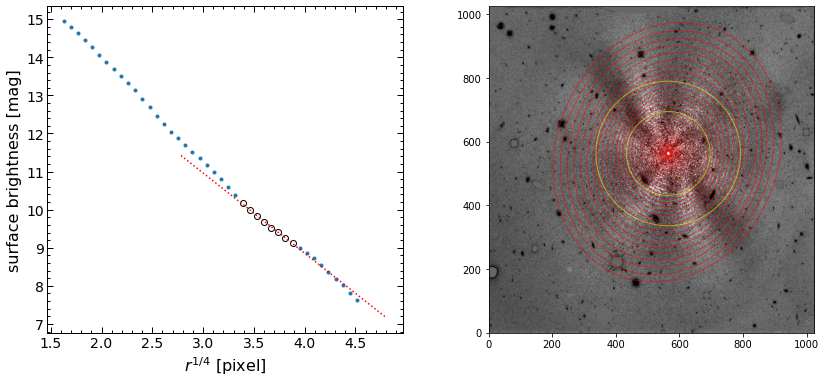

In [83]:
sky = int(sky_factor*obj.sky_med)

# using common mask --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med*sky_factor, niter=10, mask=1, model_mask=0)

model = 0
root = obj.objRoot
suffix = '.%03d'%model

ellipseFile = root+'/elliprof'+suffix
df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
df = df.apply(pd.to_numeric, errors='coerce')

# fig, ax = plt.subplots(1,1, figsize=(7,6))
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(14,6))

x = df.Rmaj**0.25
y = 2.5*np.log10(df.I0)
ax.plot(x, y, '.')

ax.set_xlabel(r"$r^{1/4}$"+" [pixel]", fontsize=16)
ax.set_ylabel(r"surface brightness"+" [mag]", fontsize=16)

maxX = np.max(x)
minX = np.min(x)
dx = maxX-minX
x1 = 0.60*dx+minX
x2 = maxX-0.20*dx
x0 = x[((x<x2) & (x>x1))]
y0 = y[((x<x2) & (x>x1))]
ax.plot(x0, y0, 'ko', mfc='white')

m, b = np.polyfit(x0, y0, 1)

xrange = np.linspace(x1-0.2*dx, maxX+0.1*dx, 100)
yrange = m*xrange+b

ax.plot(xrange, yrange, 'r:')
set_axes(ax, fontsize=14)

##################################################
obj.tv_resid(model=0, options='sqrt', ax=ax2)
obj.plot_ellipse(model=0, ax=ax2, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')
n_cross = Xellipses(obj.list_ellipses(model=0))
print("No. of crossing ellipses: %d"%n_cross)


## center, Smajor, Smainor, angle
Ell = make_Ellipse((obj.x0, obj.y0), min(x0)**4, min(x0)**4, 0)
e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], 
                    alpha=0.5, linewidth=1, edgecolor='yellow', facecolor='none')
ax2.add_patch(e)

Ell = make_Ellipse((obj.x0, obj.y0), max(x0)**4, max(x0)**4, 0)
e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], 
                    alpha=0.5, linewidth=1, edgecolor='yellow', facecolor='none')
ax2.add_patch(e)

Back Median: 16.83
Back Mean: 19.22
Back Stdev: 101.83


0.9124768169368881

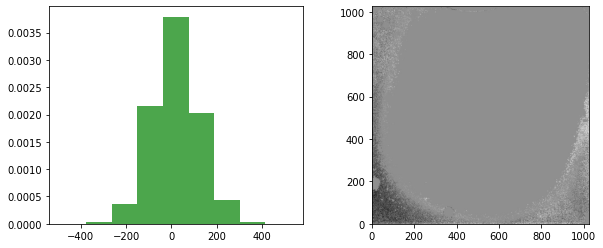

In [84]:
resid_name = obj.objRoot+"resid.000"
back_mask = obj.objRoot+"back_mask.fits"

imarray, header = imOpen(resid_name)
mskarray, header = imOpen(back_mask)

masked_image = imarray*mskarray

fits.writeto('./tmp.fits', np.float32(masked_image), overwrite=True)

## plot_2darray(imarray)
# tv('./tmp.fits', options='log')


a = masked_image
a = a[(a!=0)]
std = np.std(a)
mean = np.mean(a)

a = a[((a>mean-3.*std)&(a<mean+3.*std))]

median = np.median(a)
mean = np.mean(a)
std = np.std(a)

print("Back Median: %.2f"%median)
print("Back Mean: %.2f"%mean)
print("Back Stdev: %.2f"%std)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.hist(a, bins=np.linspace(mean-5*std, mean+5*std, 10), density=True, color='g', alpha=0.7)
tv('./tmp.fits', ax=ax2, options="")

new_factor = median/obj.sky_med + sky_factor

new_factor